### House Prices - Advanced Regression Techniques

<b>Problem Statement and Context</b>

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

Reference: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

<b>Importing required packages; Reading the Data</b>

In [1]:
import glob
import zipfile

import numpy as np
import pandas as pd
import os

from pandas.api.types import CategoricalDtype
from IPython.display import display

import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.preprocessing import LabelEncoder

from scipy.stats import norm, skew 
from scipy.special import boxcox1p

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [2]:
files = glob.glob('*.zip')
files 

['AHP_data.zip']

In [3]:
for file in files:
    print('Unzipping:', file)

    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall('Data-Files')

Unzipping: AHP_data.zip


In [4]:
os.getcwd()
# pwd

"/Users/ruchi/Desktop/Ruchi's Work/UT Acads/Codes/House Pred"

In [5]:
os.listdir("/Users/ruchi/Desktop/Ruchi's Work/UT Acads/Codes/House Pred/Data-Files")

['test.csv', 'data_description.txt', 'train.csv', 'sample_submission.csv']

In [86]:
data = pd.read_csv("Data-Files/train.csv")
data.shape

(1460, 81)

In [87]:
data = data.drop('Id', axis = 1)
data.shape

(1460, 80)

In [88]:
data.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [89]:
test = pd.read_csv("Data-Files/test.csv")
test.shape

(1459, 80)

In [90]:
test = test.drop('Id', axis = 1)
test.shape

(1459, 79)

<b>Exploratory Data Analysis</b>

<i>Taking smaller samples of the data as .csv to have a better look at the data:</i>

In [91]:
temp = data.sample(n=10)
temp.to_csv("temp.csv")

In [92]:
# data.columns
# data._get_numeric_data().columns
# data.select_dtypes(exclude=["number"]).columns

In [93]:
data.dtypes.nunique(), (data.dtypes=="object").sum(), (data.dtypes=="int64").sum(), (data.dtypes=="float64").sum()
# data.dtypes

(3, 43, 34, 3)

<i>Checking for null values in the target variable:</i>

In [94]:
data['SalePrice'].isnull().sum()

0

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

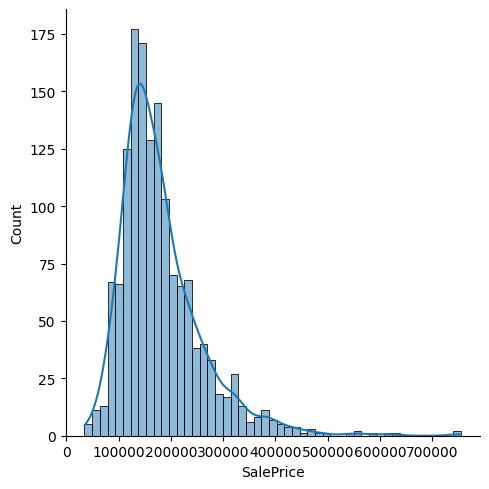

In [95]:
sns.displot(data["SalePrice"], kde=True)
data["SalePrice"].describe()

In [96]:
print('Skew:',data["SalePrice"].skew())
print('Kurt:',data["SalePrice"].kurt())

Skew: 1.8828757597682129
Kurt: 6.536281860064529


count    1460.000000
mean       12.024057
std         0.399449
min        10.460271
25%        11.775105
50%        12.001512
75%        12.273736
max        13.534474
Name: SalePrice, dtype: float64

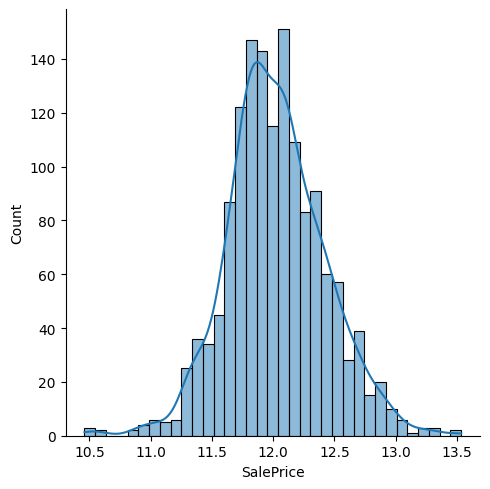

In [97]:
data["SalePrice"] = np.log1p(data["SalePrice"])
sns.displot(data["SalePrice"],kde=True)
data["SalePrice"].describe()

In [98]:
print('Skew:',data["SalePrice"].skew())
print('Kurt:',data["SalePrice"].kurt())

Skew: 0.12134661989685329
Kurt: 0.809519155707878


<i>EDA on the predictor variables:</i>

In [99]:
len(data['GarageYrBlt']), data['GarageYrBlt'].nunique(), data['GarageYrBlt'].isnull().sum(), type(data['GarageYrBlt'][0])

(1460, 97, 81, numpy.float64)

In [100]:
data['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [101]:
data['Street'].value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

In [102]:
data['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [103]:
data['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [104]:
data['ExterCond'].value_counts()

TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64

In [105]:
data['Exterior2nd'].value_counts()

VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
Other        1
CBlock       1
Name: Exterior2nd, dtype: int64

In [106]:
data['Street'].value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

<i>Imputing missing values</i>

In [107]:
for name in data.select_dtypes('number'):
    data[name] = data[name].fillna(0)
    
for name in data.select_dtypes('category'):
    data[name] = data[name].fillna('None')

In [108]:
# display(data.info())
# display(test.info())

In [109]:
df = pd.concat((data, test)).reset_index(drop=True)
df.drop(['SalePrice'], axis=1, inplace=True)

data_na = df.isnull().sum()/len(df)*100
data_na = data_na.drop(data_na[data_na==0].index).sort_values(ascending = False)[:30]
missing = pd.DataFrame({'Missing %age': data_na})
missing.head()

,Missing %age
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797


In [110]:
df.shape

(2919, 79)

Text(0.5, 1.0, 'Features Correlating with Sales Price')

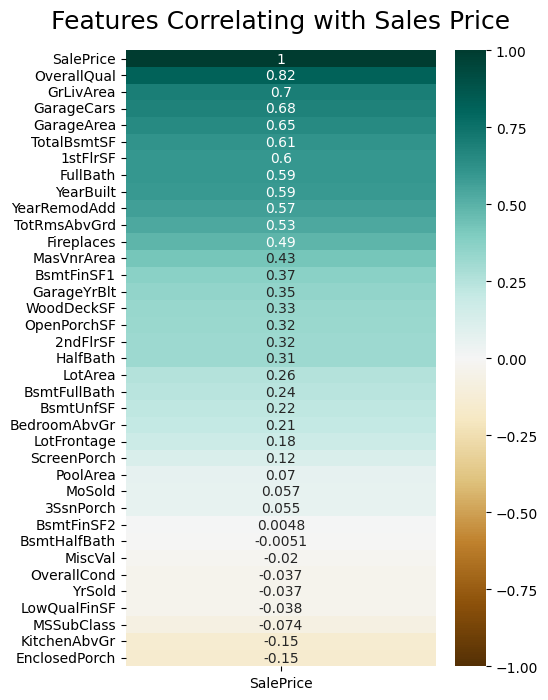

In [111]:
plt.figure(figsize=(5, 8))
heatmap = sns.heatmap(data.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Sales Price', fontdict={'fontsize':18}, pad=16)

In [112]:
df["PoolQC"] = df["PoolQC"].fillna("None")
df["MiscFeature"] = df["MiscFeature"].fillna("None")
df["Alley"] = df["Alley"].fillna("None")
df["Fence"] = df["Fence"].fillna("None")
df["FireplaceQu"] = df["FireplaceQu"].fillna("None")

df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    df[col] = df[col].fillna('None')
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    df[col] = df[col].fillna(0)
    
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    df[col] = df[col].fillna(0)
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df[col] = df[col].fillna('None')
    
df["MasVnrType"] = df["MasVnrType"].fillna("None")
df["MasVnrArea"] = df["MasVnrArea"].fillna(0)
df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])
df = df.drop(['Utilities'], axis=1)
df["Functional"] = df["Functional"].fillna("Typ")
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])
df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])
df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
df['MSSubClass'] = df['MSSubClass'].fillna("None")

data_na = (df.isnull().sum() / len(df)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
missing = pd.DataFrame({'Missing Ratio': data_na})
missing.head()

,Missing Ratio


<i>Feature Encoding</i>

In [113]:
# MSSubClass = The building class
df['MSSubClass'] = df['MSSubClass'].apply(str)


# Changing OverallCond into a categorical variable
df['OverallCond'] = df['OverallCond'].astype(str)


# Year and month sold are transformed into categorical features
df['YrSold'] = df['YrSold'].astype(str)
df['MoSold'] = df['MoSold'].astype(str)

In [114]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(df[c].values)) 
    df[c] = lbl.transform(list(df[c].values))

print('Shape all_data: {}'.format(df.shape))

Shape all_data: (2919, 78)


In [115]:
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

<i>Checking skew of all numeric features and performing box-cox transformation:</i>

In [116]:
numeric_features = df.dtypes[df.dtypes != "object"].index

skewed_features = df[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

skewness = pd.DataFrame({'Skew': skewed_features})
skewness.head(10)

,Skew
MiscVal,21.947195
PoolArea,16.898328
LotArea,12.822431
LowQualFinSF,12.088761
3SsnPorch,11.376065
LandSlope,4.975157
KitchenAbvGr,4.302254
BsmtFinSF2,4.146143
EnclosedPorch,4.003891
ScreenPorch,3.946694


In [117]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    df[feat] = boxcox1p(df[feat], lam)

There are 59 skewed numerical features to Box Cox transform


In [118]:
df.shape

(2919, 79)

In [119]:
df = pd.get_dummies(df)

In [120]:
df.shape

(2919, 221)

In [121]:
len(data), len(test), len(df)

(1460, 1459, 2919)

In [39]:
train = df[:len(data)]
test = df[len(data):]

In [40]:
y_train = data.SalePrice.values

In [84]:
train.shape

(1460, 221)

In [85]:
test.shape

(1459, 221)

<b>Modeling</b>

In [42]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle = True, random_state = 10).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring = "neg_mean_squared_error", cv = kf))
    return(rmse)

In [43]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.0005, random_state = 1))
score = rmsle_cv(lasso)

print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1237 (0.0161)



In [44]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score = rmsle_cv(ENet)

print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1238 (0.0162)



In [45]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1266 (0.0128)



In [46]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1239 (0.0125)



In [47]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, 
                             random_state =7, nthread = -1)


score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1227 (0.0108)



In [48]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [49]:
lasso.fit(train, y_train)
lasso_train_pred = lasso.predict(train)
lasso_pred = np.expm1(lasso.predict(test))
print(rmsle(y_train, lasso_train_pred))

0.10672870425361701


In [50]:
ENet.fit(train, y_train)
ENet_train_pred = ENet.predict(train)
ENet_pred = np.expm1(ENet.predict(test))
print(rmsle(y_train, ENet_train_pred))

0.10598271634408458


In [51]:
KRR.fit(train, y_train)
KRR_train_pred = KRR.predict(train)
KRR_pred = np.expm1(KRR.predict(test))
print(rmsle(y_train, KRR_train_pred))

0.08748154649574748


In [52]:
GBoost.fit(train, y_train)
gb_train_pred = GBoost.predict(train)
gb_pred = np.expm1(GBoost.predict(test))
print(rmsle(y_train, gb_train_pred))

# best

0.055627341612191974


In [53]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.07915612937977488


In [79]:
# Final Output based on GBoost 

#'''
sub = pd.DataFrame()
sub['SalePrice'] = gb_pred
sub.to_csv('submission00.csv',index=False)
#'''

In [82]:
sub.head() 

,SalePrice
0,121652.093292
1,156746.530295
2,192070.163334
3,194855.600789
4,185381.156746


<b>Diving into regularized linear regression models & xgb</b>

In [55]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

# this is aqctually rmsle only 
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

<i>Starting with Ridge:</i>

In [56]:
model_ridge = Ridge()

In [57]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

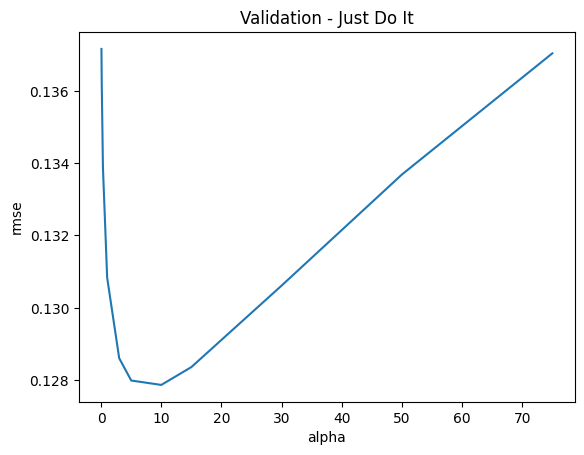

In [58]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [59]:
cv_ridge.min()

0.127867935691841

<i>Moving to Lasso:</i>

In [60]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(train, y_train)

In [61]:
rmse_cv(model_lasso).mean()

0.1252148555328606

The lasso performs even better so we can just use this one to predict on the test set. Another neat thing about the Lasso is that it does feature selection. Let's take a look at the coefficients:

In [62]:
coef = pd.Series(model_lasso.coef_, index = train.columns)

In [63]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 97 variables and eliminated the other 124 variables


One thing to note here however is that the features selected are not necessarily the "correct" ones - especially since there are a lot of collinear features in this dataset. One idea to try here is run Lasso a few times on boostrapped samples and see how stable the feature selection is.

In [64]:
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

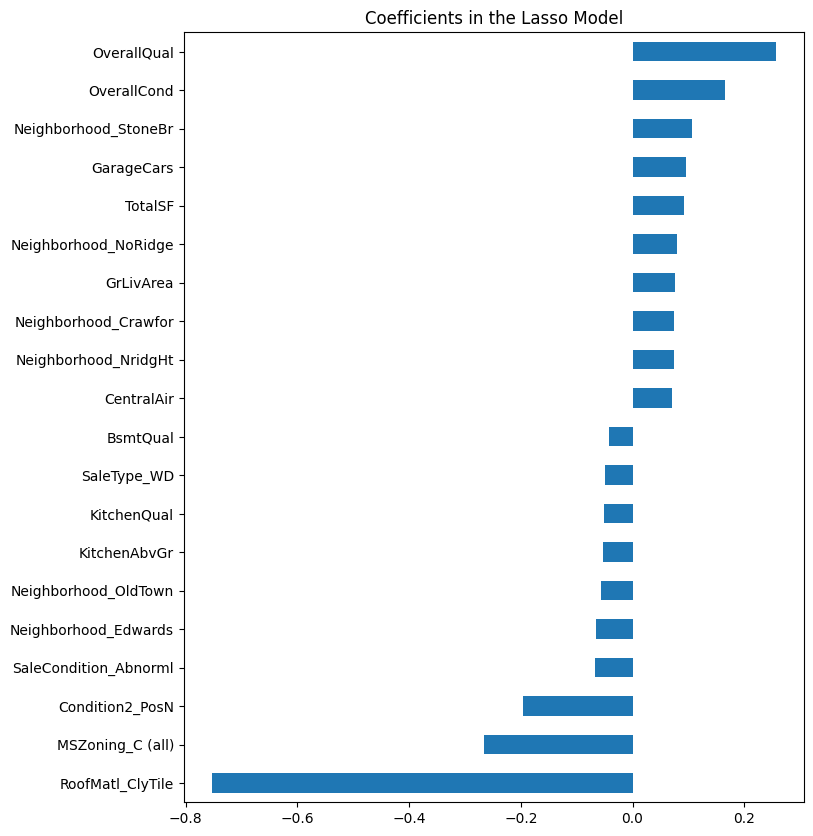

In [65]:
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

Note that unlike the feature importance you'd get from a random forest these are _actual_ coefficients in your model - so you can say precisely why the predicted price is what it is. The only issue here is that we log_transformed both the target and the numeric features so the actual magnitudes are a bit hard to interpret. 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='preds', ylabel='residuals'>

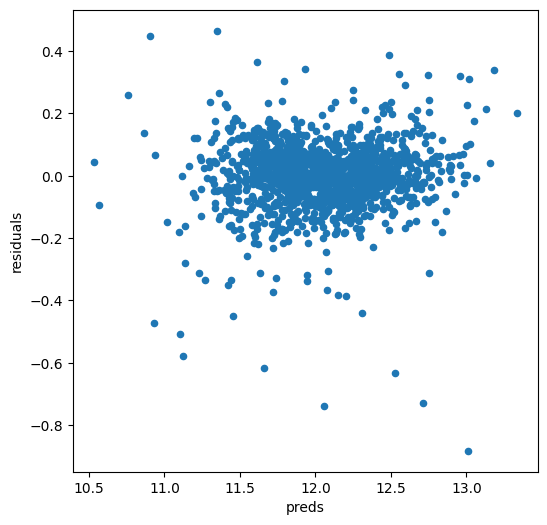

In [66]:
#let's look at the residuals as well:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

<i>Compairing Lasso and XGB:</i>

In [68]:
dtrain = xgb.DMatrix(train, label = y_train)
dtest = xgb.DMatrix(test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

<AxesSubplot: >

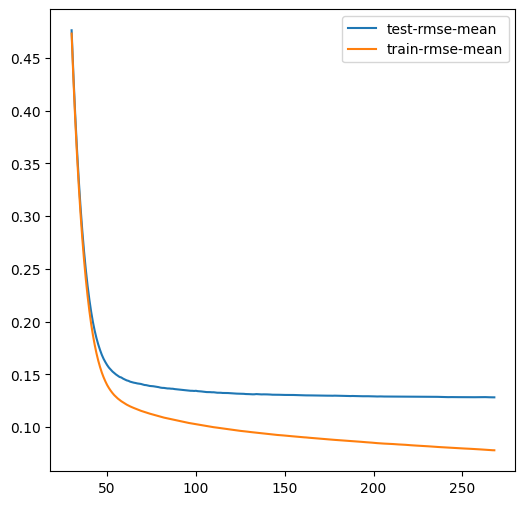

In [69]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [70]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=2, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=360, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [71]:
xgb_preds = np.expm1(model_xgb.predict(test))
lasso_preds = np.expm1(model_lasso.predict(test))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='xgb', ylabel='lasso'>

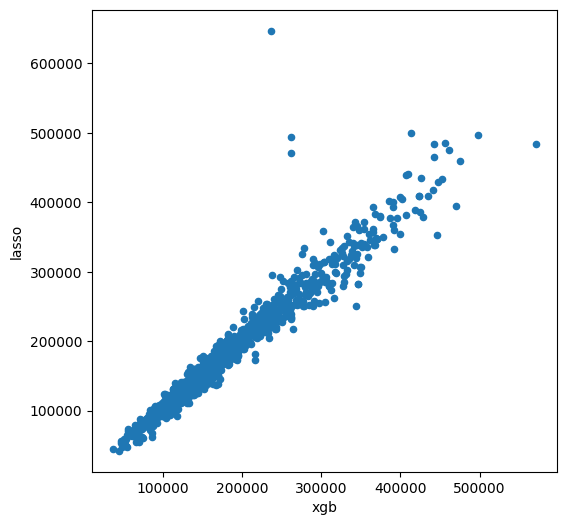

In [72]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

Many times it makes sense to take a weighted average of uncorrelated results - this usually imporoves the score although in this case it doesn't help that much.

In [73]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [76]:
#'''
solution = pd.DataFrame({"SalePrice":preds})
solution.to_csv("Solution01.csv", index = False)
#'''

In [83]:
solution.head()  

,SalePrice
0,119259.553252
1,158005.347442
2,184317.747538
3,197088.925720
4,199182.966134


<i>Extra Notes:</i>
1. Make a dataframe or some tabulation of the value counts of each feature when there are too many features - can do a crosstab but the problem is that each of the x's have different types of values 
2. What's the impact of skewness in data on the model and overall performance?
3. RMSLE vs RMSE